In [122]:
import os
import sys

sys.path.append(os.path.join('.', 'pytorch_yolo_v3'))

In [123]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas


        
def prep_image(orig_im, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

#     orig_im = cv2.imread(img)
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def prep_image_pil(img, network_dim):
    orig_im = Image.open(img)
    img = orig_im.convert('RGB')
    dim = img.size
    img = img.resize(network_dim)
    img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    img = img.view(*network_dim, 3).transpose(0,1).transpose(0,2).contiguous()
    img = img.view(1, 3,*network_dim)
    img = img.float().div(255.0)
    return (img, orig_im, dim)

def inp_to_image(inp):
    inp = inp.cpu().squeeze()
    inp = inp*255
    try:
        inp = inp.data.numpy()
    except RuntimeError:
        inp = inp.numpy()
    inp = inp.transpose(1,2,0)

    inp = inp[:,:,::-1]
    return inp

In [125]:
colors = pkl.load(open("pytorch_yolo_v3/pallete", "rb"))

def write(x, results):
    c1 = tuple(map(lambda x: int(x.item()*1.6), tuple(x[1:3].int())))
    c2 = tuple(map(lambda x: int(x.item()*1.6), tuple(x[3:5].int())))
#     c1 = tuple(x[1:3].int())
#     c2 = tuple(x[3:5].int())
    img = results
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

In [5]:
model = Darknet("pytorch_yolo_v3/cfg/yolov3.cfg")
model.load_weights("pytorch_yolo_v3/yolov3.weights")

In [6]:
num_classes = 80
classes = load_classes('pytorch_yolo_v3/data/coco.names') 

In [7]:
_ = model.cuda()

In [8]:
CUDA = torch.cuda.is_available()

In [9]:
videofile = './Novgorod_2019-04-05-15_15_00.mp4'
cap = cv2.VideoCapture(videofile)

In [35]:
prediction

tensor([[  0.0000, 137.9324,  47.3085, 295.1749, 115.4737,   0.9999,   0.9999,
           2.0000],
        [  0.0000, -21.9213,  76.5757, 111.8205, 149.9649,   0.9977,   0.9686,
           2.0000]], device='cuda:0')

In [126]:
def get_iou(box1: iter, box2: iter) -> float:
    """
    Calculate intersection over union (IOU) between bbox yolo type from
        recognition and tracking

    Arguments:
        box1 {iter} -- bbox yolo type
        box2 {iter} -- bbox yolo type

    Returns:
        float -- IOU result
    """

    tb = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2]) - \
        max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2])
    lr = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3]) - \
        max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3])
    if tb < 0 or lr < 0:
        intersection = 0
    else:
        intersection = tb * lr
    return intersection / (box1[2] * box1[3] +
                           box2[2] * box2[3] - intersection)

In [337]:
get_iou((303, 134, 107, 254),(303, 129, 109, 253))

0.9440450196161971

In [127]:
def getbbox_p1p2(pred):
    c1 = tuple(map(lambda x: int(x.item()*1.6), tuple(pred[1:3].int())))
    c2 = tuple(map(lambda x: int(x.item()*1.6), tuple(pred[3:5].int())))
    bbox = c1+c2
    bbox = [x if x>0 else 0 for x in bbox]
    bbox = [x if x<511 else 511 for x in bbox]
    return bbox

In [128]:
def p1p2Tocxcywh(a):
    x = int((a[2]-a[0])/2 + a[0])
    y = int((a[3]-a[1])/2 + a[1])
    w = int(a[3]-a[1])
    h = int(a[2]-a[0])
    return (x,y,w,h)

In [250]:
def draw_trackers(frame):
    for tracker in trackers.values():
        bbox = tracker['bbox']
        color = tracker['color']
        frame = cv2.rectangle(frame, tuple(bbox[0:2]), tuple(bbox[2:4]), color, 10, 1)
    return frame

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


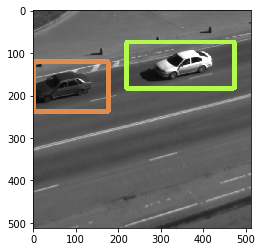

In [564]:
global_track_id_cnt = 0
nms_conf = 0.5
confidence = 0.5

trackers = dict(dict())

videofile = './Novgorod_2019-04-05-15_15_00.mp4'
cap = cv2.VideoCapture(videofile)

ret, frame = cap.read()
frame = frame[1500:2500,1500:2500]
frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()

with torch.no_grad():
    prediction = model(img, CUDA)
prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_conf)

for i,pred in enumerate(prediction):
    tracker = cv2.TrackerMOSSE_create()
    bbox = getbbox_p1p2(pred)
    tracker.init(frame, (bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]))
    
    global_track_id_cnt += 1
    
    trc = {}
    trc['tracker'] = tracker
    trc['bbox']  = bbox
    trc['color'] = tuple([np.random.randint(0,255) for i in range(3)])
    trackers[global_track_id_cnt] = trc
    frame = draw_trackers(frame)
    
plt.imshow(frame)

In [565]:
def preprocess_prediction(pred, iou_thresh, frame_cpy, global_track_id_cnt):
    pred_bbox = getbbox_p1p2(pred)
    bb1 = p1p2Tocxcywh(pred_bbox)
    set_newtracker = True
    
    for tracker_id, tracker in trackers.items():
        bb2 = p1p2Tocxcywh(tracker['bbox'])
        iou = get_iou(bb1, bb2)
        if iou > iou_thresh:
            set_newtracker = False
            tracker['tracker'].init(frame, (pred_bbox[0], pred_bbox[1], pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1]))
            tracker['bbox'] = pred_bbox
            color = tracker['color']
#             cv2.rectangle(frame_cpy, tuple(pred_bbox[0:2]), tuple(pred_bbox[2:4]), color, 10, 1)
                
    if set_newtracker:
        global_track_id_cnt += 1
        tracker = cv2.TrackerMOSSE_create()
        tracker.init(frame, (pred_bbox[0], pred_bbox[1], pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1]))
        
        trc = {}
        trc['tracker'] = tracker
        trc['bbox']  = pred_bbox
        trc['color'] = tuple([np.random.randint(0,255) for i in range(3)])
        trackers[global_track_id_cnt] = trc  
#         cv2.rectangle(frame_cpy, tuple(pred_bbox[0:2]), tuple(pred_bbox[2:4]), trc['color'], 10, 1)
    return frame_cpy, global_track_id_cnt

In [566]:
iou_thresh = 0.2
interested = ['car', 'backpack', 'motorbike', 'truck', 'train', 'suitcase']

while cap.isOpened():
#     time.sleep(1)
    try:
        ret, frame = cap.read()
        frame = frame[1500:2500,1500:2500]
        frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        frame_cpy = frame.copy()
        img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()
        

        with torch.no_grad():
            prediction = model(img, CUDA)
        prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_thesh)    
        a = list(map(lambda x: write(x, frame_cpy), prediction))
        
        print('==='*5)
        trackers_for_delete = []
        for tracker_id, tracker in trackers.items():
            ok, bbox = tracker['tracker'].update(frame)
            if ok:
                p1 = (int(bbox[0]), int(bbox[1]))
                p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
#                 if p1[0] < 5:
#                     trackers_for_delete.append(tracker_id)
            else:
                trackers_for_delete.append(tracker_id)
        
        for tracker_id in trackers_for_delete:
            print('deleted', tracker_id)
            trackers.pop(tracker_id)
            
        for pred in prediction:
            if classes[int(pred[-1].item())] in interested:
                frame_cpy, global_track_id_cnt = preprocess_prediction(pred, iou_thresh, frame_cpy, global_track_id_cnt)
                
        draw_trackers(frame_cpy)
        cv2.putText(frame_cpy, f"Trackers: {len(trackers)}, {global_track_id_cnt}", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

        cv2.imshow('video', frame_cpy)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    except Exception(e):
        print(e)
        cv2.destroyAllWindows()
        break

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


deleted 2
deleted 3
deleted 1
deleted 5
deleted 4
deleted 6
deleted 7
deleted 8
deleted 9
deleted 10
deleted 11
deleted 12


In [537]:
100*20

2000

In [475]:
global_track_id_cnt

69

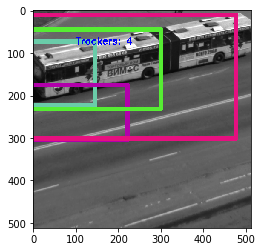

In [448]:
plt.imshow(frame)

In [447]:
trackers

{13: {'bbox': (-14, 74, 145, 224),
  'color': (106, 204, 169),
  'tracker': <TrackerKCF 00000181E5450A70>},
 16: {'bbox': (-30, 176, 222, 304),
  'color': (178, 0, 171),
  'tracker': <TrackerKCF 00000181D0B33610>},
 17: {'bbox': (-53, 45, 300, 232),
  'color': (86, 237, 51),
  'tracker': <TrackerKCF 00000181D0B33970>},
 22: {'bbox': (-35, 11, 476, 302),
  'color': (230, 16, 128),
  'tracker': <TrackerKCF 00000181D0B335F0>}}

In [402]:
cv2.destroyAllWindows()

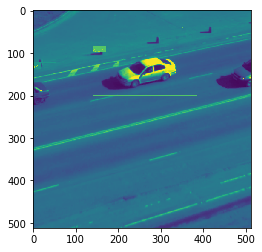

In [283]:
plt.imshow(frame[:,:,0])

In [168]:
videofile = './Novgorod_2019-04-05-15_15_00.mp4'
cap = cv2.VideoCapture(videofile)
_, frame = cap.read()

In [209]:
while cap.isOpened():
#     for i in range(pass_step):
#         cap.read()
    try:
        ret, frame = cap.read()
        frame = frame[1500:2500,1500:2500]
        frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()

        with torch.no_grad():
            prediction = model(img, CUDA)
        prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_thesh)
        a = list(map(lambda x: write(x, frame), prediction))

        cv2.imshow('video', a[0])
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    except Exception(e):
        print(e)
        cv2.destroyAllWindows()
        break

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
